In [1]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('data/Stroma Integrated Program Plan-Table 1.csv')

In [7]:
df.head()

,Row ID,Task Name,Health,% Complete,Sub system,SF Role,Task type,Status,Lead / Support,Assigned To,...,Actual Fees,Remaining Budget,Budget $ Wk/Wk,Billed Hours - 1 wk,$ Budget - 1 wk,Kantata Code,Type,Baseline Start,Baseline Finish,Variance
0,1,Stroma Program,Green,66%,NaN,NaN,NaN,NaN,NaN,NaN,...,"US$9,044,956.62","US$634,948.76",#NO MATCH,#NO MATCH,#NO MATCH,NaN,NaN,NaN,NaN,NaN
1,2,1103-1X,Blue,100%,NaN,NaN,NaN,NaN,NaN,NaN,...,"US$63,664.12",US$0.00,US$0.00,296.15,"US$63,664.12",NaN,NaN,NaN,NaN,NaN
2,3,1103-2X,Blue,100%,NaN,NaN,NaN,NaN,NaN,NaN,...,"US$2,190.00",US$0.00,US$0.00,20.5,"US$2,190.00",NaN,NaN,NaN,NaN,NaN
3,4,1103-2X1,Blue,100%,NaN,NaN,NaN,NaN,NaN,NaN,...,"US$96,232.42",US$0.00,US$0.00,468.83,"US$96,232.42",NaN,NaN,NaN,NaN,NaN
4,5,1103-1,Blue,100%,NaN,NaN,NaN,NaN,NaN,NaN,...,"US$433,079.28",US$0.00,US$0.00,2031.11666666667,"US$433,079.28",NaN,NaN,NaN,NaN,NaN


Splitting up the DataFrame into three based on line types. 

In [109]:
task_df = df[df['Type']=='task']

In [17]:
deliverable_df = df[df['Type']=='deliverable']

In [18]:
milestone_df = df[df['Type']=='milestone']

In [22]:
print("Milestone DF: ", len(milestone_df))
print("Deliverable DF: ", len(deliverable_df))
print("Task DF: ", len(task_df))

Milestone DF:  24
Deliverable DF:  125
Task DF:  289


##### Tasks DF
Dropping columns that are unnecessary 

In [110]:
task_df = task_df.drop(['Sub system','Task Budget','Status', 'Task type', 'SF Role', 'Optimistic Days', 'Kantata Code', 'Task Numbers', 'Health', 'Lead / Support', 'Assigned To', 'Days Till Finish', 'Type'], axis=1)

In [129]:
money_cols = ['Remaining Budget', 'Budget $ Wk/Wk', '$ Budget - 1 wk']

Adding values to nulls for baseline start, baseline finish, variance. 

In [131]:
# task_df.loc[task_df['Baseline Start'].isnull(), 'Baseline Start'] = task_df['Start']
# task_df.loc[task_df['Baseline Finish'].isnull(), 'Baseline Finish'] = task_df['Finish']
# task_df.loc[task_df['Variance'].isnull(), 'Variance'] = 0
# task_df.loc[task_df['% Complete'].isnull(), '% Complete'] = 0
# task_df.loc[task_df['Actual Fees'].isnull(), 'Actual Fees'] = task_df['Budget $ Wk/Wk']
# task_df.loc[task_df['WK/WK Change - Hours'] == '#NO MATCH', 'WK/WK Change - Hours'] = 0
# task_df[money_cols] = task_df[money_cols].astype('string')
# task_df = task_df.drop(59)
# task_df = task_df.drop(53)

In [132]:
for col in money_cols:
    task_df[col] = task_df[col].str.replace(r'^US\$', '', regex=True)
    task_df[col] = task_df[col].str.replace(r'^--US\$', '-', regex=True)

In [143]:
task_df.head()

,Row ID,Task Name,% Complete,Duration,Start,Finish,Budget Days,Budget Hours,ETC Hours,% Hours Billed,...,% $ Budget Billed,CPI,Actual Fees,Remaining Budget,Budget $ Wk/Wk,Billed Hours - 1 wk,$ Budget - 1 wk,Baseline Start,Baseline Finish,Variance
15,16,Project Management activities,75%,25d,09/04/24,10/09/24,12.500,100.0,0.0,105%,...,0%,0.71,"28,896.50","-28,896.50",0.00,105.00,"28,896.50",09/04/24,10/09/24,0
16,17,PM Admin / Support activities,75%,25d,09/04/24,10/09/24,3.125,25.0,10.0,39%,...,0%,1.91,"1,378.33","-1,378.33",110.50,9.33,"1,267.83",09/04/24,10/09/24,0
19,20,Implement fine-grid simulation,100%,25d,07/29/24,08/30/24,4.125,33.0,0.0,124%,...,0%,0.80,"11,476.00",0.00,0.00,41.00,"11,476.00",07/29/24,08/30/24,0
20,21,Run function,100%,25d,07/29/24,08/30/24,1.625,13.0,0.0,71%,...,0%,1.41,"2,717.75",0.00,0.00,9.25,"2,717.75",07/29/24,08/30/24,0
21,22,Beam aiming for position errors,100%,25d,07/29/24,08/30/24,5.000,40.0,0.0,164%,...,0%,0.61,"18,278.50",0.00,0.00,65.75,"18,278.50",07/29/24,08/30/24,0


In [144]:
cat_cols = ['Task Name', 'Row ID', '% Complete', 'Duration', 'Start', 'Finish', 'Baseline Start', 'Baseline Finish', '% Hours Billed', '% $ Budget Billed', 'Variance']


In [136]:
task_df = task_df.replace('#NO MATCH', '0')

In [145]:
task_df[cat_cols]=task_df[cat_cols].astype('string')
for col in task_df.select_dtypes(include=['object']).columns:
    task_df[col] = task_df[col].astype('float64')

In [146]:
task_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287 entries, 15 to 550
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row ID                287 non-null    string 
 1   Task Name             287 non-null    string 
 2   % Complete            287 non-null    string 
 3   Duration              287 non-null    string 
 4   Start                 287 non-null    string 
 5   Finish                287 non-null    string 
 6   Budget Days           287 non-null    float64
 7   Budget Hours          287 non-null    float64
 8   ETC Hours             287 non-null    float64
 9   % Hours Billed        287 non-null    string 
 10  Billed Hours          287 non-null    float64
 11  WK/WK Change - Hours  287 non-null    float64
 12  Projected Ov/Un       287 non-null    float64
 13  % $ Budget Billed     287 non-null    string 
 14  CPI                   287 non-null    float64
 15  Actual Fees           287 n

In [147]:
task_df.to_pickle('task_df_clean')

Splitting into cat and num

In [153]:
num_task_df = task_df.select_dtypes(include='number')

In [160]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [161]:
inertia = []
cluster_range = range(1, 11)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(num_task_df)
    inertia.append(kmeans.inertia_)

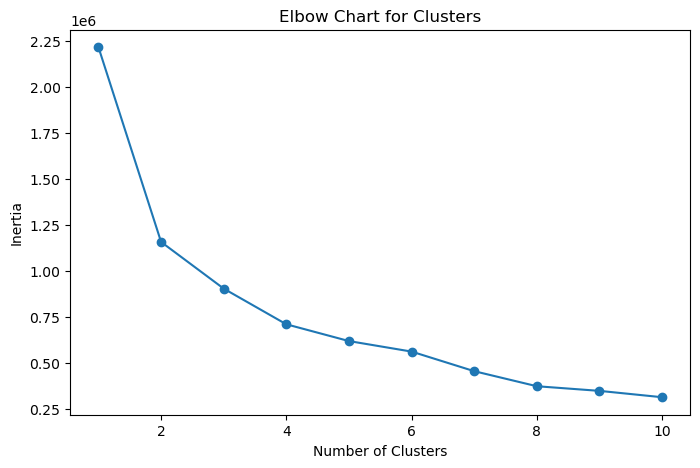

In [162]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Chart for Clusters')
plt.show()

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(num_task_df)
num_task_scaled_df = pd.DataFrame(scaled_data, columns=num_task_df.columns)

In [ ]:
pca = PCA(n_components=4)
pca.fit_transform(num_task_scaled_df)

,Budget Days,Budget Hours,ETC Hours,Billed Hours,WK/WK Change - Hours,Projected Ov/Un,CPI,Billed Hours - 1 wk
0,0.283768,0.283768,0.000000,0.329929,0.275019,0.500351,0.022187,0.396601
1,0.070942,0.070942,0.083333,0.030888,0.276920,0.522677,0.059687,0.035241
2,0.093644,0.093644,0.000000,0.128830,0.275019,0.493765,0.025000,0.154863
3,0.036890,0.036890,0.000000,0.029065,0.275019,0.519560,0.044062,0.034939
4,0.113507,0.113507,0.000000,0.206599,0.275019,0.454799,0.019062,0.248347
